In [2]:
import numpy as np
from gpcam.gp_optimizer import GPOptimizer
import matplotlib.pyplot as plt
from numpy.random import default_rng

import plotly.graph_objects as go
import numpy as np

In [2]:
def plot(x,y,z,data = None):
    fig = go.Figure()
    fig.add_trace(go.Surface(x = x, y = y,z=z))
    if data is not None: 
        fig.add_trace(go.Scatter3d(x=data[:,0], y=data[:,1], z=data[:,2],
                                   mode='markers'))

    fig.update_layout(title='Posterior Mean', autosize=True,
                  width=800, height=800,
                  margin=dict(l=65, r=50, b=65, t=90))

    fig.show()


In [3]:
a = np.load("/Users/davide/Downloads/us_topo.npy")
rng = default_rng()
ind = rng.choice(len(a)-1, size=50, replace=False)
points = a[ind,0:2]
values = a[ind,2:3]
print("x_min ", np.min(points[:,0])," x_max ",np.max(points[:,0]))
print("y_min ", np.min(points[:,1])," y_max ",np.max(points[:,1]))
print("length of data set: ", len(points))

index_set_bounds = np.array([[0,99],[0,248]])
hyperparameter_bounds = np.array([[0.001,1e9],[1,1000],[1,1000]])
hps_guess = np.array([4.71907062e+06, 4.07439017e+02, 3.59068120e+02])

x_min  3.0  x_max  94.0
y_min  4.0  y_max  242.0
length of data set:  50


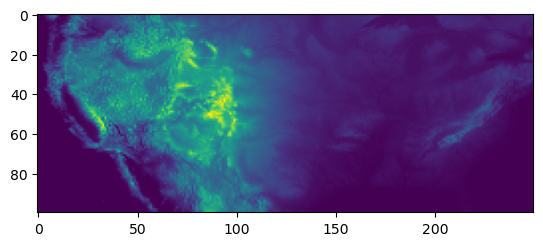

In [4]:
plt.figure()
plt.imshow(a[:,2].reshape(100,250))


In [5]:
gp = GPOptimizer(2, index_set_bounds)
gp.tell(points,values)
gp.init_gp(hps_guess)
gp.train_gp(hyperparameter_bounds,pop_size = 20,tolerance = 1e-6,max_iter = 2)

array([1.13915238e+08, 2.95285854e+02, 1.32719969e+02])

In [34]:
x_pred = np.empty((10000,2))
counter = 0
x = np.linspace(0,99,100)
y = np.linspace(0,248,100)

for i in x:
 for j in y:
   x_pred[counter] = np.array([i,j])
   counter += 1


In [35]:
res1 = gp.posterior_mean(x_pred)

In [36]:
res2 = gp.posterior_covariance(x_pred)
# #res3 = gp.gp.shannon_information_gain(x_pred)
# X,Y = np.meshgrid(x,y)

# PM = np.reshape(res1["f(x)"],(100,250))
# PV = np.reshape(res2["v(x)"],(100,250))
# # plot(X,Y,PM)
# # plot(X,Y,PV)


In [40]:
X,Y = np.meshgrid(x,y)

PM = np.reshape(res1["f(x)"],(100,100))
PV = np.reshape(res2["v(x)"],(100,100))
# plot(X,Y,PM)
# plot(X,Y,PV)


In [41]:
plot(X,Y,PM)
plot(X,Y,PV)

In [49]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()  # Launches a scheduler and workers locally
client = Client(cluster)  #

/opt/anaconda3/envs/gpcam/lib/python3.8/site-packages/distributed/node.py:182: UserWarning:

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 56095 instead



In [4]:
# cluster.close()

In [14]:

next = gp.ask(position = None, n = 5, acquisition_function = "variance", bounds = None,
             method = "hgdl", pop_size = 50, max_iter = 20,
             tol = 10e-6, dask_client = client)
print(next)

NameError: name 'client' is not defined

In [15]:
next['x'][:,1]

TypeError: 'builtin_function_or_method' object is not subscriptable

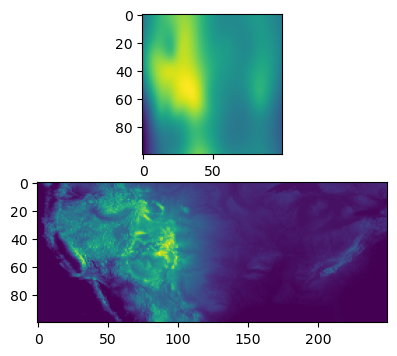

In [42]:
fig,ax=plt.subplots(2,1,figsize=(8,4))
ax[0].imshow(PM)
ax[1].imshow(a[:,2].reshape(100,250))

# plt.scatter(next['x'][:,1]/2.48,next['x'][:,0]/.99)

In [78]:
res2

{'x': array([[  0.        ,   0.        ],
        [  0.        ,   2.50505051],
        [  0.        ,   5.01010101],
        ...,
        [ 99.        , 242.98989899],
        [ 99.        , 245.49494949],
        [ 99.        , 248.        ]]),
 'v(x)': array([558925.78665066, 302447.63041091, 146318.61196852, ...,
        132661.41573179,  19338.33483958, 476688.47066987]),
 'S(x)': array([[ 5.58925787e+05,  3.53214840e+05,  1.78952475e+05, ...,
          3.81594300e-01,  1.96184427e-01,  2.84394659e-01],
        [ 3.53214840e+05,  3.02447630e+05,  1.78236232e+05, ...,
          2.82079466e-01,  1.39271386e-01,  1.81247592e-01],
        [ 1.78952475e+05,  1.78236232e+05,  1.46318612e+05, ...,
          1.92050144e-01,  9.37290117e-02,  1.17169991e-01],
        ...,
        [ 3.81593376e-01,  2.82079443e-01,  1.92050561e-01, ...,
          1.32661416e+05, -1.23906304e+04, -1.43801536e+05],
        [ 1.96183927e-01,  1.39271498e-01,  9.37294066e-02, ...,
         -1.23906304e+04,  1.

In [74]:
res1['x'][199]

array([  1., 248.])

# Trying to predict experiment point

In [1]:
import numpy as np
from gpcam.gp_optimizer import GPOptimizer
import matplotlib.pyplot as plt
from numpy.random import default_rng

import plotly.graph_objects as go
import numpy as np

In [11]:
def init_gp(points,values,index_set_bounds,hyperparameter_bounds,hps_guess):
    gp = GPOptimizer(2, index_set_bounds)
    gp.tell(points,values)
    gp.init_gp(hps_guess)
    gp.train_gp(hyperparameter_bounds,pop_size = 20,tolerance = 1e-6,max_iter = 2)
    return gp


def find_next(points,values,gp):
    gp.tell(points,values)
    gp.train_gp(hyperparameter_bounds,pop_size = 20,tolerance = 1e-6,max_iter = 2)

    new = gp.ask(position = None, n = 1, acquisition_function = "shannon_ig", bounds = None,
        method = "global", pop_size = 20, max_iter = 20, tol = 10e-6, x0 = None, dask_client = False)
    
    x,y = np.round(new['x'][0]).astype(int)
    return x,y

def measure_next(a,new):
    newval = a[new[0]*250+new[1]]
    assert np.allclose(new,newval[:2]),"coordinates don't match"
    # points.append(new)
    # values.append(a[new[0]*250+new[1]])
    return newval[2]
    # new,a[new[0]*250+new[1]][2]



In [12]:
%%time
a = np.load("/Users/davide/Downloads/us_topo.npy")
rng = default_rng()
ind = rng.choice(len(a)-1, size=5, replace=False)
points = a[ind,0:2]
values = a[ind,2:3]
print("x_min ", np.min(points[:,0])," x_max ",np.max(points[:,0]))
print("y_min ", np.min(points[:,1])," y_max ",np.max(points[:,1]))
print("length of data set: ", len(points))

index_set_bounds = np.array([[0,99],[0,248]])
hyperparameter_bounds = np.array([[0.001,1e9],[1,1000],[1,1000]])
hps_guess = np.array([4.71907062e+06, 4.07439017e+02, 3.59068120e+02])

gp = init_gp(points,values,index_set_bounds,hyperparameter_bounds,hps_guess)
# gp = GPOptimizer(2, index_set_bounds)
# gp.tell(points,values)
# gp.init_gp(hps_guess)
# gp.train_gp(hyperparameter_bounds,pop_size = 20,tolerance = 1e-6,max_iter = 2)


# new = gp.ask(position = None, n = 1, acquisition_function = "covariance", bounds = None,
#      method = "global", pop_size = 20, max_iter = 20, tol = 10e-6, x0 = None, dask_client = False)

x_min  0.0  x_max  98.0
y_min  86.0  y_max  240.0
length of data set:  5
CPU times: user 83.3 ms, sys: 7.82 ms, total: 91.1 ms
Wall time: 102 ms


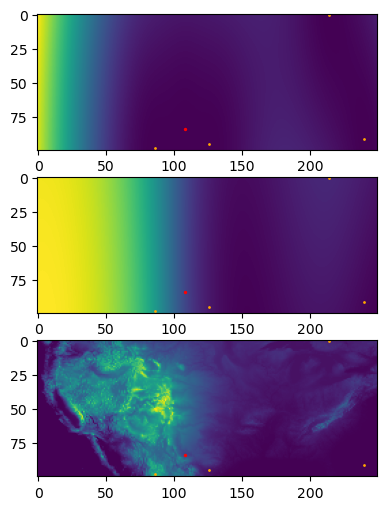

In [13]:
x_pred = np.empty((25000,2))
counter = 0
x = np.linspace(0,99,100)
y = np.linspace(0,248,250)

for i in x:
 for j in y:
   x_pred[counter] = np.array([i,j])
   counter += 1

res1 = gp.posterior_mean(x_pred)
res2 = gp.posterior_covariance(x_pred)


X,Y = np.meshgrid(x,y)

PM = np.reshape(res1["f(x)"],(100,250))
PV = np.reshape(res2["v(x)"],(100,250))


fig,ax=plt.subplots(3,1,figsize=(8,6))
ax[0].imshow(PV)
ax[1].imshow(PM)
ax[2].imshow(a[:,2].reshape(100,250))
for aa in ax:
    aa.scatter(points[:-1,1],points[:-1,0],s=1,color='orange')
    aa.scatter(points[-1,1],points[-1,0],s=2,color='red')
    

In [15]:
newpoint = find_next(points,values,gp)
newval = measure_next(a,newpoint)
values = np.append(values,newval)
points = np.append(points,np.array(newpoint)[None,:],axis=0)

print(values.shape,points.shape)
print(newpoint,newval)



(53,) (53, 2)
(99, 14) 0.0


In [14]:
from tqdm.auto import tqdm
for i in tqdm(range(100)):
    newpoint = find_next(points,values,gp)
    newval = measure_next(a,newpoint)
    values = np.append(values,newval)
    points = np.append(points,np.array(newpoint)[None,:],axis=0)

    # print(values.shape,points.shape)
    # print(newpoint,newval)



  0%|          | 0/100 [00:00<?, ?it/s]

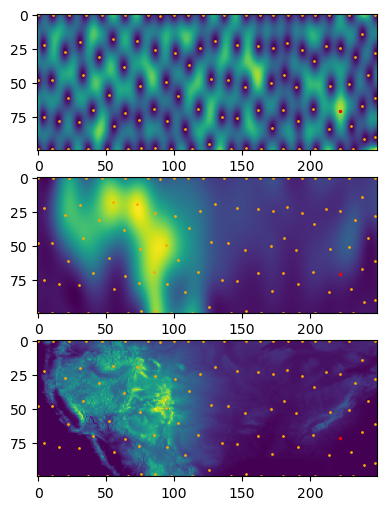

In [15]:
x_pred = np.empty((25000,2))
counter = 0
x = np.linspace(0,99,100)
y = np.linspace(0,248,250)

for i in x:
 for j in y:
   x_pred[counter] = np.array([i,j])
   counter += 1

res1 = gp.posterior_mean(x_pred)
res2 = gp.posterior_covariance(x_pred)


X,Y = np.meshgrid(x,y)

PM = np.reshape(res1["f(x)"],(100,250))
PV = np.reshape(res2["v(x)"],(100,250))


fig,ax=plt.subplots(3,1,figsize=(8,6))
ax[0].imshow(PV)
ax[1].imshow(PM)
ax[2].imshow(a[:,2].reshape(100,250))
for aa in ax:
    aa.scatter(points[:-1,1],points[:-1,0],s=1,color='orange')
    aa.scatter(points[-1,1],points[-1,0],s=2,color='red')
    